# 1 数据生成

In [1]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader

## 1.1 回归类数据集

### 1.1.1 手动创建回归类数据集

生成两个特征、存在偏差，自变量和因变量存在线性关系的数据集

In [2]:
num_inputs = 2               # 两个特征
num_examples = 1000          # 总共一千条数据

然后尝试通过线性方程，确定自变量和因变量的真实关系

In [3]:
torch.manual_seed(420)       # 设置随机数种子

In [4]:
# 线性方程系数
w_true = torch.tensor([2., -1]).reshape(2, 1)
b_true = torch.tensor(1.)

# 特征和标签取值
features = torch.randn(num_examples, num_inputs)
labels_true = torch.mm(features, w_true) + b_true
labels = labels_true + torch.randn(size = labels_true.shape) * 0.01

> 此处设置所有的数据都是浮点型。

注意，此时labels_true和features满足严格意义上的线性方程关系

$$y = 2x_1-x_2+1$$

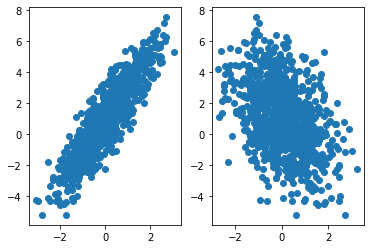

In [9]:
plt.subplot(121)
plt.scatter(features[:, 0], labels)          # 第一个特征和标签的关系
plt.subplot(122)
plt.scatter(features[:, 1], labels)          # 第二个特征和标签的关系

不难看出，两个特征和标签都存在一定的线性关系，并且跟特征的系数绝对值有很大关系。当然，若要增加线性模型的建模难度，可以增加扰动项的数值比例，从而削弱线性关系。

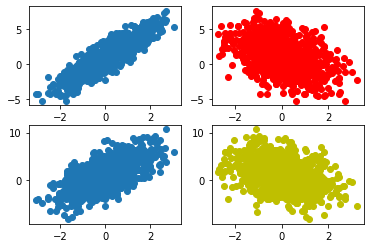

In [11]:
# 设置随机数种子
torch.manual_seed(420)   

# 修改因变量
labels1 = labels_true + torch.randn(size = labels_true.shape) * 2

# 可视化展示

# 扰动较小的情况
plt.subplot(221)
plt.scatter(features[:, 0], labels)             # 第一个特征和标签的关系
plt.subplot(222)
plt.plot(features[:, 1], labels, 'ro')          # 第二个特征和标签的关系

# 扰动较大的情况
plt.subplot(223)
plt.scatter(features[:, 0], labels1)             # 第一个特征和标签的关系
plt.subplot(224)
plt.plot(features[:, 1], labels1, 'yo')          # 第二个特征和标签的关系

当然，我们也能生成非线性关系的数据集，此处我们创建满足$y=x^2+1$规律的数据集。

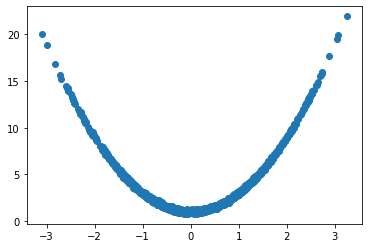

In [12]:
# 设置随机数种子
torch.manual_seed(420)   

num_inputs = 2               # 两个特征
num_examples = 1000          # 总共一千条数据

# 线性方程系数
w_true = torch.tensor(2.)
b_true = torch.tensor(1.)

# 特征和标签取值
features = torch.randn(num_examples, num_inputs)
labels_true = torch.pow(features, 2) * w_true + b_true
labels = labels_true + torch.randn(size = labels_true.shape) * 0.1

# 可视化展示
plt.scatter(features, labels)

### 1.1.2 回归类数据生成函数

In [18]:
def tensorGenReg(num_examples = 1000, w = [2, -1, 1], bias = True, delta = 0.01, deg = 1):
    """回归类数据集创建函数。

    :param num_examples: 创建数据集的数据量
    :param w: 包括截距的（如果存在）特征系数向量
    :param bias：是否需要截距
    :param delta：扰动项取值
    :param deg：方程次数
    :return: 生成的特征张和标签张量
    """
    
    if bias == True:
        num_inputs = len(w)-1                                                        # 特征张量
        features_true = torch.randn(num_examples, num_inputs)                        # 不包含全是1的列的特征张量
        w_true = torch.tensor(w[:-1]).reshape(-1, 1).float()                         # 自变量系数
        b_true = torch.tensor(w[-1]).float()                                         # 截距
        if num_inputs == 1:                                                          # 若输入特征只有1个，则不能使用矩阵乘法
            labels_true = torch.pow(features_true, deg) * w_true + b_true
        else:
            labels_true = torch.mm(torch.pow(features_true, deg), w_true) + b_true
        features = torch.cat((features_true, torch.ones(len(features_true), 1)), 1)  # 在特征张量的最后添加一列全是1的列
        labels = labels_true + torch.randn(size = labels_true.shape) * delta         
                
    else: 
        num_inputs = len(w)
        features = torch.randn(num_examples, num_inputs)
        w_true = torch.tensor(w).reshape(-1, 1).float()
        if num_inputs == 1:
            labels_true = torch.pow(features, deg) * w_true
        else:
            labels_true = torch.mm(torch.pow(features, deg), w_true)
        labels = labels_true + torch.randn(size = labels_true.shape) * delta
    return features, labels

In [19]:
# 设置随机数种子
torch.manual_seed(420)   

# 扰动项取值为0.01
f, l = tensorGenReg(delta=0.01)

f

tensor([[-0.0070,  0.5044,  1.0000],
        [ 0.6704, -0.3829,  1.0000],
        [ 0.0302,  0.3826,  1.0000],
        ...,
        [-0.9164, -0.6087,  1.0000],
        [ 0.7815,  1.2865,  1.0000],
        [ 1.4819,  1.1390,  1.0000]])

In [20]:
f.shape

torch.Size([1000, 3])

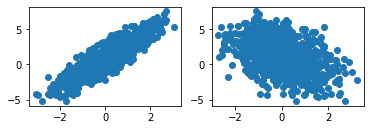

In [21]:
# 绘制图像查看结果
plt.subplot(223)
plt.scatter(f[:, 0], l)             # 第一个特征和标签的关系
plt.subplot(224)
plt.scatter(f[:, 1], l)          # 第二个特征和标签的关系

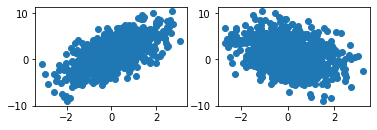

In [22]:
# 设置随机数种子
torch.manual_seed(420)   

# 扰动项取值为2
f, l = tensorGenReg(delta=2)

# 绘制图像查看结果
plt.subplot(223)
plt.scatter(f[:, 0], l)             # 第一个特征和标签的关系
plt.subplot(224)
plt.scatter(f[:, 1], l)          # 第二个特征和标签的关系

当特征和标签满足二阶关系时候数据表现

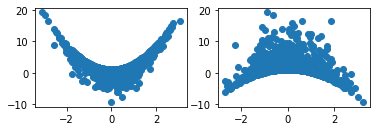

In [23]:
# 设置随机数种子
torch.manual_seed(420)   

# 2阶方程
f, l = tensorGenReg(deg=2)

# 绘制图像查看结果
plt.subplot(223)
plt.scatter(f[:, 0], l)             # 第一个特征和标签的关系
plt.subplot(224)
plt.scatter(f[:, 1], l)          # 第二个特征和标签的关系

当只有一个特征时数据表现

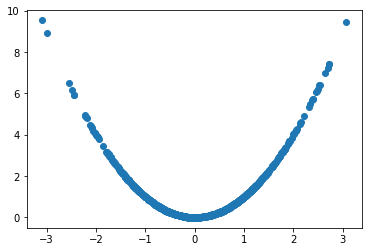

In [24]:
# 设置随机数种子
torch.manual_seed(420)   

# 2阶方程
f, l = tensorGenReg(w=[1], deg=2, bias=False)
plt.scatter(f, l)

## 1.2 分类数据集

### 1.2.1 手动创建分类数据集

接下来尝试创建一个拥有两个特征的三分类的数据集，每个类别包含500条数据，并且第一个类别的两个特征都服从均值为4、标准差为2的正态分布，第二个类别的两个特征都服从均值为-2、标准差为2的正态分布，第三个类别的两个特征都服从均值为-6、标准差为2的正态分布，创建过程如下:

In [26]:
# 设置随机数种子
torch.manual_seed(420)   

# 创建初始标记值
num_inputs = 2
num_examples = 500

# 创建自变量簇
data0 = torch.normal(4, 2, size=(num_examples, num_inputs))
data1 = torch.normal(-2, 2, size=(num_examples, num_inputs))
data2 = torch.normal(-6, 2, size=(num_examples, num_inputs))

# 创建标签
label0 = torch.zeros(500)
label1 = torch.ones(500)
label2 = torch.full_like(label1, 2)

# 合并生成最终数据
features = torch.cat((data0, data1, data2)).float()
labels = torch.cat((label0, label1, label2)).long().reshape(-1, 1)

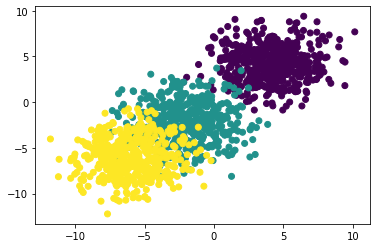

In [27]:
# 可视化展示
plt.scatter(features[:, 0], features[:, 1], c = labels)

能够看出，类别彼此交叉情况较少，分类器在此数据集上会有不错表现。当然，若要增加分类器的分类难度，可以将各类的均值压缩，并增加方差，从而增加从二维图像上来看彼此交错的情况。

In [29]:
# 设置随机数种子
torch.manual_seed(420)   

# 创建初始标记值
num_inputs = 2
num_examples = 500

# 创建自变量簇
data0 = torch.normal(3, 2, size=(num_examples, num_inputs))
data1 = torch.normal(0, 2, size=(num_examples, num_inputs))
data2 = torch.normal(-3, 2, size=(num_examples, num_inputs))

# 创建标签
label0 = torch.zeros(500)
label1 = torch.ones(500)
label2 = torch.full_like(label1, 2)

# 合并生成最终数据
features1 = torch.cat((data0, data1, data2)).float()
labels1 = torch.cat((label0, label1, label2)).long().reshape(-1, 1)

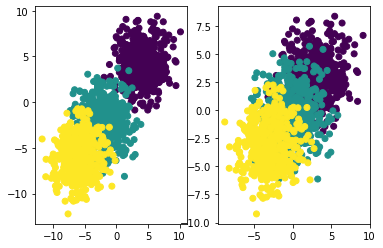

In [30]:
# 可视化展示
plt.subplot(121)
plt.scatter(features[:, 0], features[:, 1], c = labels)             
plt.subplot(122)
plt.scatter(features1[:, 0], features1[:, 1], c = labels1)

### 1.2.2 分类数据生成函数

&emsp;&emsp;同样，我们将上述创建分类函数的过程封装为一个函数。这里需要注意的是，我们希望找到一个变量可以控制数据整体离散程度，也就是后续建模的难以程度。这里我们规定，如果每个分类数据集中心点较近、且每个类别的点内部方差较大，则数据集整体离散程度较高，反之离散程度较低。在实际函数创建过程中，我们也希望能够找到对应的参数能够方便进行自主调节。

In [32]:
def tensorGenCla(num_examples = 500, num_inputs = 2, num_class = 3, deg_dispersion = [4, 2], bias = False):
    """分类数据集创建函数。
    
    :param num_examples: 每个类别的数据数量
    :param num_inputs: 数据集特征数量
    :param num_class：数据集标签类别总数
    :param deg_dispersion：数据分布离散程度参数，需要输入一个列表，其中第一个参数表示每个类别数组均值的参考、第二个参数表示随机数组标准差。
    :param bias：建立模型逻辑回归模型时是否带入截距
    :return: 生成的特征张量和标签张量，其中特征张量是浮点型二维数组，标签张量是长正型二维数组。
    """
    
    cluster_l = torch.empty(num_examples, 1)                         # 每一类标签张量的形状
    mean_ = deg_dispersion[0]                                        # 每一类特征张量的均值的参考值
    std_ = deg_dispersion[1]                                         # 每一类特征张量的方差
    lf = []                                                          # 用于存储每一类特征张量的列表容器
    ll = []                                                          # 用于存储每一类标签张量的列表容器
    k = mean_ * (num_class-1) / 2                                    # 每一类特征张量均值的惩罚因子（视频中部分是+1，实际应该是-1）
    
    for i in range(num_class):
        data_temp = torch.normal(i*mean_-k, std_, size=(num_examples, num_inputs))     # 生成每一类张量
        lf.append(data_temp)                                                           # 将每一类张量添加到lf中
        labels_temp = torch.full_like(cluster_l, i)                                    # 生成类一类的标签
        ll.append(labels_temp)                                                         # 将每一类标签添加到ll中
        
    features = torch.cat(lf).float()
    labels = torch.cat(ll).long()
    
    if bias == True:
        features = torch.cat((features, torch.ones(len(features), 1)), 1)              # 在特征张量中添加一列全是1的列
    return features, labels

&emsp;&emsp;函数整体结构不复杂，且所使用的方法都是此前介绍过的tensor常用方法，唯一需要注意的是函数对于分布离散程度的控制。函数内部变量k是一个随着均值增加和分类类别数量增加而增加的数值，且分类数量增加对k值增加影响是通过和1取平均后进行惩罚的结果。而i*mean_则是一个随着i增加稳步增量的量，二者相减最终能获得一个整体特征均匀分布在0附近的特征张量。

在使用函数的过程中，离散度的第一个数值可以理解为簇的大概分布区间，第二个数值可以理解为每个簇的离散程度。

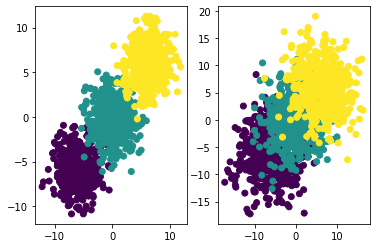

In [33]:
# 设置随机数种子
torch.manual_seed(420)   

# 创建数据
f, l = tensorGenCla(deg_dispersion = [6, 2])          # 离散程度较小
f1, l1 = tensorGenCla(deg_dispersion = [6, 4])        # 离散程度较大

# 绘制图像查看
plt.subplot(121)
plt.scatter(f[:, 0], f[:, 1], c = l)
plt.subplot(122)
plt.scatter(f1[:, 0], f1[:, 1], c = l1)

## 1.3 小批量切分函数

&emsp;&emsp;在深度学习建模过程中，梯度下降是最常用的求解目标函数的优化方法，而针对不同类型、拥有不同函数特性的目标函数，所使用的梯度下降算法也各有不同。目前为止，我们判断小批量梯度下降（MBGD）是较为“普适”的优化算法，它既拥有随机梯度下降（SGD）的能够跨越局部最小值点的特性，同时又和批量梯度下降（BGD）一样，拥有相对较快的收敛速度（虽然速度略慢与BGD）。而在小批量梯度下降过程中，我们需要对函数进行分批量的切分，因此，在手动实现各类深度学习基础算法之前，我们需要定义数据集小批量切分的函数。

shuffle过程：将原序列乱序排列

In [34]:
l = list(range(5))
l

[0, 1, 2, 3, 4]

In [35]:
random.shuffle(l)
l

[1, 2, 0, 3, 4]

批量切分函数的目标就是根据设置的“批数”，将原数据集随机均匀切分。可通过如下函数实现：

In [36]:
def data_iter(batch_size, features, labels):
    """
    数据切分函数
    
    :param batch_size: 每个子数据集包含多少数据
    :param featurs: 输入的特征张量
    :param labels：输入的标签张量
    :return l：包含batch_size个列表，每个列表切分后的特征和标签所组成 
    """
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    l = []
    for i in range(0, num_examples, batch_size):
        j = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        l.append([torch.index_select(features, 0, j), torch.index_select(labels, 0, j)])
    return l

In [37]:
for i in range(0, 5, 2):
    print(i)

0
2
4


In [38]:
# 设置随机数种子
torch.manual_seed(420)  

# 生成二分类数据集
features, labels = tensorGenCla()       

In [39]:
features[:5]

tensor([[-4.0141, -2.9911],
        [-2.6593, -4.7657],
        [-3.9395, -3.2347],
        [-5.0262, -2.5792],
        [-0.3817, -3.1295]])

In [40]:
torch.tensor(l[0:2])

tensor([1, 2])

In [41]:
torch.index_select(features, 0, torch.tensor(l[0:2]))

tensor([[-2.6593, -4.7657],
        [-3.9395, -3.2347]])

In [42]:
labels

tensor([[0],
        [0],
        [0],
        ...,
        [2],
        [2],
        [2]])

In [43]:
l = data_iter(10, features, labels)

In [44]:
l[0]                                     # 查看切分后的第一个数据集 

[tensor([[-4.8027, -1.2258],
         [-0.8141,  1.4812],
         [ 5.2814,  4.7111],
         [-2.9201, -6.5820],
         [ 0.0701,  0.6402],
         [ 2.4170,  4.6280],
         [-6.5269, -3.6554],
         [-2.3818, -4.0387],
         [-4.3734, -4.7677],
         [ 3.8664,  3.2436]]),
 tensor([[0],
         [1],
         [2],
         [0],
         [1],
         [2],
         [0],
         [0],
         [0],
         [2]])]

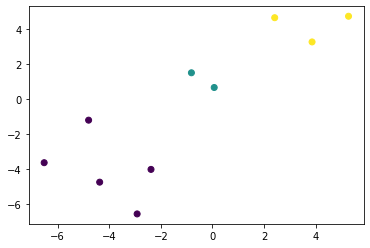

In [45]:
plt.scatter(l[0][0][:, 0], l[0][0][:, 1], c = l[0][1])

> 此处又使用了空列表用于存储数据。在经典机器学习领域，我们经常使用空的列表来存储经过处理之后的数据，这么做能让我们非常清楚的看到数据的真实情况，但在深度学习领域，这么做却不是常规操作。在深度学习领域，数据量往往非常大，甚至数据本身就是分布式存储的，要调取数据进行完整的查看，一方面会耗费大量的存储空间，另一方面也会消耗一定的算力，因此PyTorch的Dataset和DataLoader都是将数据进行迭代存储或者映射存储。关于数据生成器大的相关内容我们将在后续进行讨论，此处由于我们是进行手动实验，将处理完的数据完整的存在列表容器中则是为了方便调用查看，是一种更适合初学者的方法。